In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import gc

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2023_06_12_tea_seq_atac_processing/")

path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

In [2]:
## Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))

In [3]:
new_cluster_order = pd.read_csv("/media/kyle_storage/kyle_ferchen/"\
    "grimes_lab_main/data/2021_11_mouse_optimized_cite_seq/processed_files/"\
    "r7_cluster_order_kf_2024_01.csv")
map_r7_to_lv3 = pd.Series(\
    new_cluster_order["Level 3"].values,
    index=new_cluster_order["Cluster"].values)
map_lvl3_to_order = pd.Series(\
    new_cluster_order["Order"].values,
    index=new_cluster_order["Level 3"].values)
map_r7_to_replace_dash = pd.Series(\
    new_cluster_order["Cluster"].values,
    index=[i.replace("-", "_") for i in new_cluster_order["Cluster"].values])
new_cluster_order

,Cluster,Group,Old_order,CITE-to-TEA,Order,Level 1,Level 2,Level 3,Level Kairavee
0,LT-HSC_Mllt3,HSCP,1,LT-HSC_Mllt3,1.0,HSPC,HSC,qHSC,HSC
1,ST-HSC,HSCP,2,ST-HSC,2.0,HSPC,HSC,aHSC,HSC
2,MPP4-Hlf,HSCP,3,MPP4-Hlf,3.0,HSPC,MPP4,HSC-Ly,HSPC
3,MPP5-Egr1,HSCP,8,MPP5-Egr1,4.0,HSPC,MPP5,MPP5-IER,MPP5-IER
4,MPP5-Flt3,HSCP,7,MPP5-Flt3,5.0,HSPC,MPP5,MPP5 Ly-I,HSPC
...,...,...,...,...,...,...,...,...,...
83,ILC2,ILC,84,ILC2,84.0,ILC,ILC,ILC2,ILC
84,Bcl11b+_preETP_Cd3d,ILC,85,Bcl11b+_preETP_Cd3d,85.0,T cell,preETP,pre-ILC1-ILC3-NKP,preETP
85,Bcl11b+_preETP_Tdrd5,ILC,88,Bcl11b+_preETP_Tdrd5,86.0,T cell,preETP,pre-NKP,preETP
86,ILC1-ILC3-NKP,ILC,87,ILC1-ILC3-NKP,87.0,ILC,ILC,ILC1-ILC3-NKP,ILC


In [4]:
# Seqlet annotation
seqlets = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_anno.fea")

# Seqlets
dp_scores = pd.read_feather("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/all_seqlit_hits_above_modisco_min_dp_scores.fea")
dp_scores = dp_scores.set_index("index").astype(np.float32)
dp_scores = dp_scores.rename(map_r7_to_replace_dash.to_dict(), axis=1)
dp_scores = dp_scores.rename(map_r7_to_lv3.to_dict(), axis=1)

In [5]:
sig_conns = pd.read_csv("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/correlate_seqlets_to_gene_expression/sig_conns.csv")

sig_conns

,Gene,seqlet_idx,r
0,Mrpl15,1856496,0.441411
1,Mrpl15,1856497,0.467160
2,Mrpl15,2458694,0.544898
3,Mrpl15,2807710,0.544757
4,Mrpl15,3763246,0.544713
...,...,...,...
22706190,Hccs,14808102,0.621244
22706191,Hccs,14808105,0.430966
22706192,Hccs,15314097,0.439063
22706193,Hccs,15796481,0.439211


In [6]:
# Load CITE-seq data (SoupX 0.15 corrected)
path_to_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

cite_adata = anndata.read_h5ad(os.path.join(\
    path_to_cite_data,
    "cite_seq_adata_rna_combined_SoupX_0_15_with_R7_clusters.h5ad"))

cite_adata.X = np.log2((10000 * (cite_adata.X.T / \
    cite_adata.X.sum(axis=1).T).T) + 1)

cite_adata.obs["lvl3"] = cite_adata.obs["R7"].replace(\
    map_r7_to_lv3.to_dict()).values
cite_adata.obs["cluster_order"] = cite_adata.obs["lvl3"].replace(\
    map_lvl3_to_order.to_dict()).values

cite_adata = cite_adata[\
    cite_adata.obs.loc[cite_adata.obs["lvl3"] != "MEP-UNK"].sort_values(\
        by="cluster_order").index.values,
    :]

cite_df = pd.DataFrame(\
    cite_adata.X,
    index=cite_adata.obs.index.values,
    columns=cite_adata.var.index.values)

cite_rna = cite_df.copy()
cite_rna["cluster"] = cite_adata.obs.loc[\
    cite_rna.index.values, "lvl3"].values
cite_rna = pd.pivot_table(cite_rna, index="cluster", aggfunc=np.mean)

In [7]:
### Read in the results from previous analysis of seqlet to gene expression cor
## Gene clusters: hierarchical clusturing across seqlet to gene r values
# Read in the gene clusters
gene_clusters = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_gene_clusters.csv",
    header=None, index_col=0)
gene_clusters.index.name = None
## Seqlet clusters: MarkerFinder to hierarchical gene clusters
# Read in the seqlet clusters
marker_df = pd.read_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlet_markerfinder.csv")

marker_df["pattern"] = seqlets.loc[marker_df["seqlet_idx"].values, "pattern"].values

In [9]:
# Read in the TEA-seq markergene list
selected_markers_tea = pd.read_csv("output/chrombpnet/modisco_merged_results/"\
    "fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "marker_genes_tea_seq_cbpnet_clusters_n_50_corr_0_2.csv")


In [16]:
seqlets_to_tea_marker_genes = marker_df.loc[\
    marker_df["seqlet_idx"].isin(sig_conns.loc[sig_conns["Gene"].isin(\
        selected_markers_tea["gene"].values), "seqlet_idx"].values)]

In [23]:
# Recalculate corr df based on gene clusters and filtered seqlets
cor_df = pearson_corr_df_to_df(\
    cite_rna.loc[\
        dp_scores.columns.values,
        selected_markers_tea["gene"].values],
    dp_scores.loc[\
        seqlets_to_tea_marker_genes["seqlet_idx"].values,:].T)

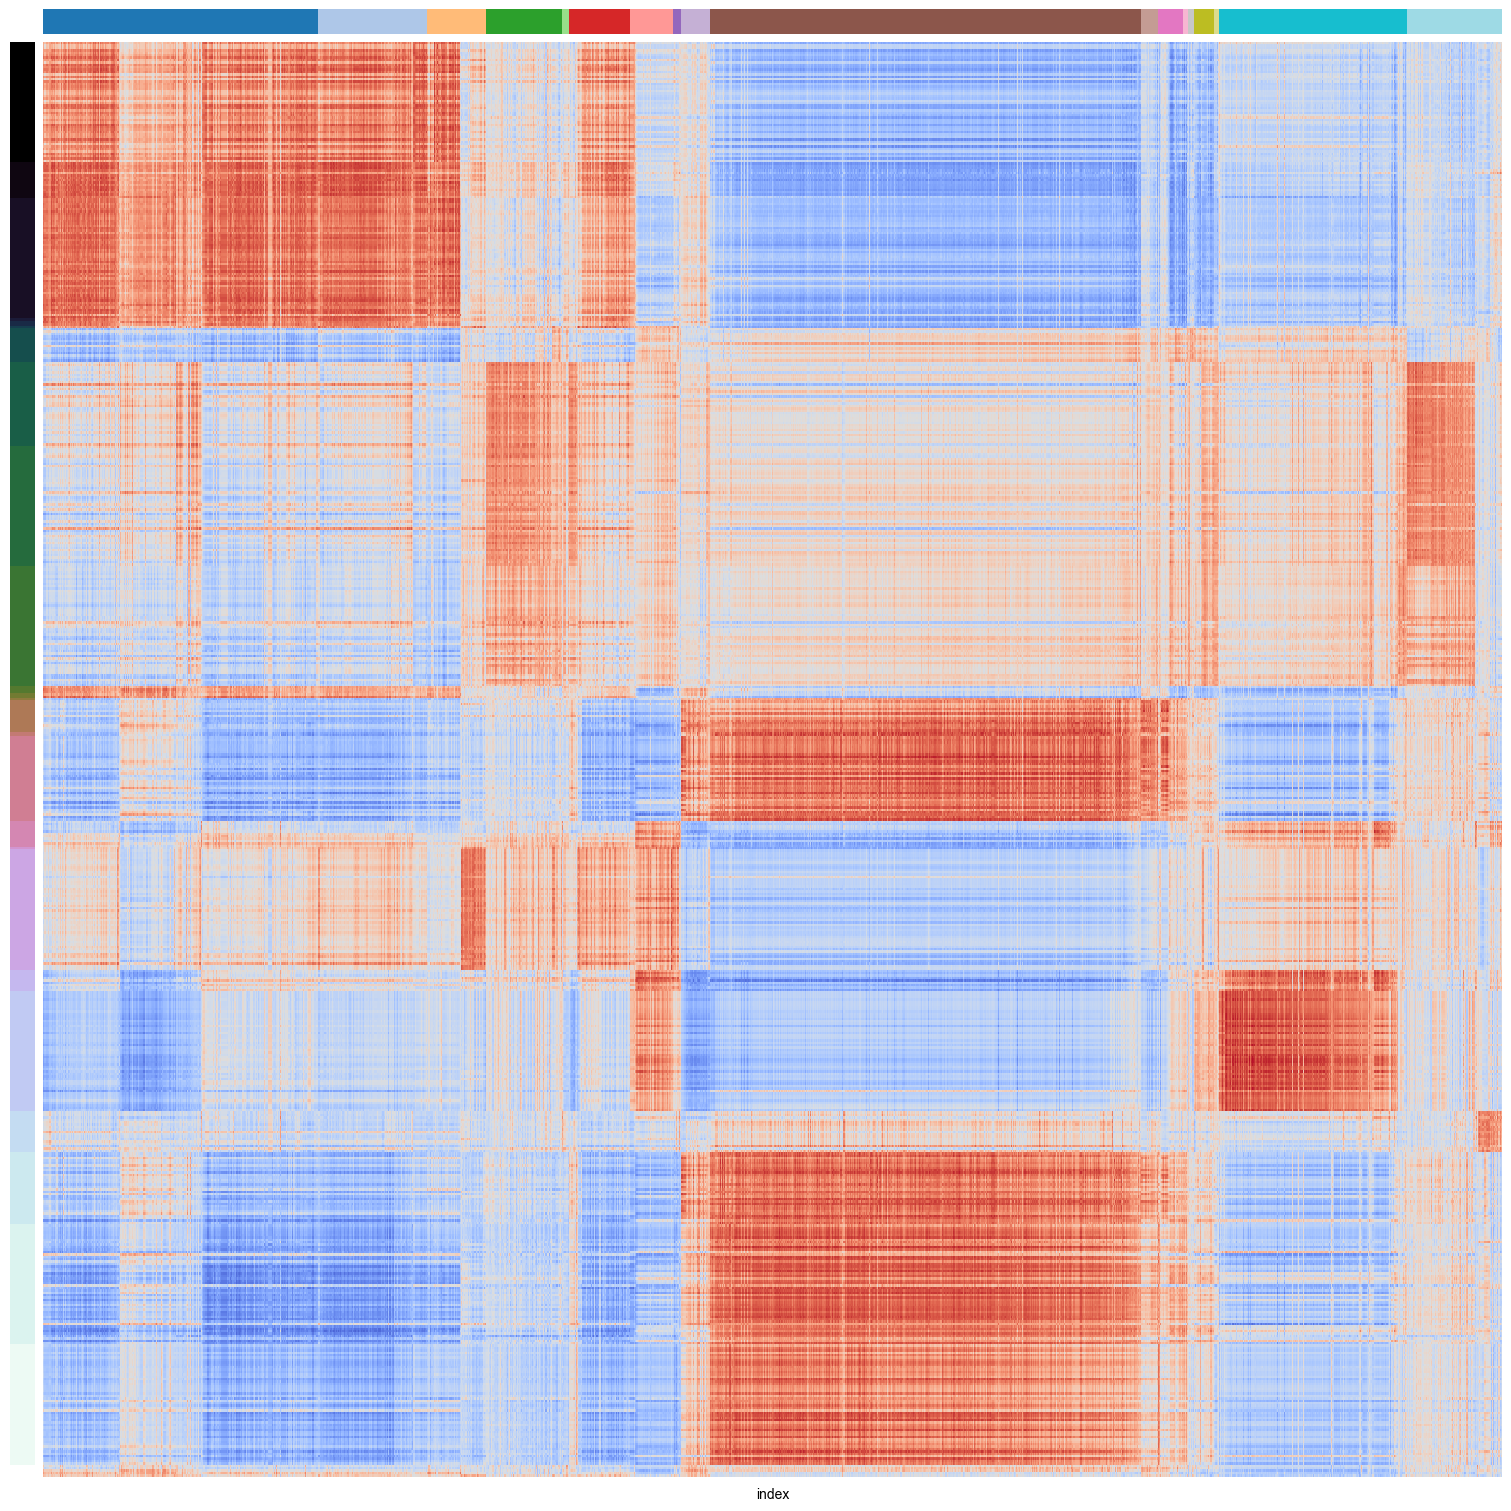

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(15,15))
ax = fig.add_gridspec(60, 60)
ax1 = fig.add_subplot(ax[1:60, 0])
ax2 = fig.add_subplot(ax[0, 1:])
ax3 = fig.add_subplot(ax[1:60, 1:])


# Cluster color bar
plot_cluster_bars = selected_markers_tea[["cluster"]].copy()
unique_clusters = plot_cluster_bars["cluster"].unique()
map_cluster_to_order = pd.Series(\
    list(range(len(unique_clusters))), 
    index=unique_clusters).to_dict()
plot_cluster_bars["cluster"] = plot_cluster_bars["cluster"].replace(\
    map_cluster_to_order)
plot_cluster_bars.columns.name = None




rowClusters = sns.heatmap(plot_cluster_bars.astype(np.float32),
                        cmap="cubehelix",
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

colClusters = sns.heatmap(seqlets_to_tea_marker_genes[["gene_cluster"]].T.astype(np.float32),
                        cmap="tab20",
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax2)

heat1 = sns.heatmap(cor_df, 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    ax=ax3,
    rasterized=True)


plt.savefig("output/FINAL_FIGURES_DIR/gene_seqlet_corr_tea_seq_marker_genes.pdf")

In [45]:
### Save the Gene clusters used and Seqlet clusters used to make subplots later
# Marker genes - vertical axis
selected_markers_tea.to_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_tea_seq_marker_gene_annotation.csv",
    header=True, index=False)

# Seqlets - horizontal axis
seqlets_to_tea_marker_genes.to_csv(\
    "output/chrombpnet/modisco_merged_results/fold_0/redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_seqlets_overlapping_tea_seq_marker_genes_annotation.csv",
    header=True, index=False)
